# Analyse BlueSeis BSPF Events

## Imports and Paths

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from obspy.clients.fdsn import Client

from functions.request_data import __request_data
from functions.compute_adr_pfo import __compute_adr_pfo
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"BSPF/figures/M62_event/"


## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## Event M62
config['tbeg'] = obs.UTCDateTime("2022-11-22 16:40:20")
config['tend'] = obs.UTCDateTime("2022-11-22 16:42:30")

# config['fmin'] = 1
# config['fmax'] = 5.0

## Load Data

In [4]:
event = Client("USGS").get_events(starttime=config['tbeg']-120, endtime=config['tend'], minmagnitude=4.0)
event = event[0]

## Eventtime
config['eventtime'] = event.origins[0].time

In [95]:
st0 = obs.read("./event62_6c.mseed")

submask = "al"

# for tr in st0:
#     if "BSPF" in tr.stats.station:
#         tr.data = np.roll(tr.data, 4)

bspf0 = st0.select(station="BSPF").copy()
pfo0 = st0.select(station="PFO*").copy()
adr0 = st0.select(station="RPFO", location=submask[:2]).copy()

In [96]:
# ##load rotation
# bspf0, bspf_inv = __request_data("PY.BSPF..HJ*", config['tbeg'], config['tend'])
# bspf0.resample(40);

# ## load translation
# pfo0, pfo_inv = __request_data("II.PFO.10.BH*", config['tbeg'], config['tend'], translation_type="ACC")

# # merge to one stream
# st0 = bspf0.copy();
# st0 += pfo0.copy();

# ## ADR
# submask = "inner"
# adr0, status = __compute_adr_pfo(config['tbeg'], config['tend'], submask=submask, status=True)
# for tr in adr0:
#     tr.stats.location = "in"
# st0 += adr0.copy();

# submask = "mid"
# adr0, status = __compute_adr_pfo(config['tbeg'], config['tend'], submask=submask, status=True)
# for tr in adr0:
#     tr.stats.location = "mi"
# st0 += adr0.copy();

# submask = "all"
# adr0, status = __compute_adr_pfo(config['tbeg'], config['tend'], submask=submask, status=True)
# for tr in adr0:
#     tr.stats.location = "al"
# st0 += adr0.copy();


# st0.trim(config['tbeg']+1, config['tend']-1)

# st0.write("./event62_6c.mseed", format="MSEED")

# # st0.plot(equal_scale=False);

## Create stream for all data

In [97]:
def __makeplot_waveform_comparison_all(st_in):

    from obspy.signal.cross_correlation import correlate

    st = st_in.copy()

    # st = st.trim(st[0].stats.starttime+5, st[0].stats.endtime-15).copy()

    fig, ax = plt.subplots(9, 1, figsize=(15, 15), sharex=True)

    lw = 1.2

    font = 12

    fband = [(1.0, 6.0), (0.5, 1.0), (0.1, 0.5)]

    offset = [0, 0, 0]

    plt.subplots_adjust(hspace=0.05)

    scaling = 1e6

    idx = 0
    for _m, array in enumerate(["in", "mi", "al"]):

        _adr = st.select(location=array).copy()
        _bspf = st.select(station="BSPF").copy()

        _bspf = _bspf.detrend("simple").taper(0.1).filter("bandpass", freqmin=fband[_m][0], freqmax=fband[_m][1], zerophase=True)
        _adr = _adr.detrend("simple").taper(0.1).filter("bandpass", freqmin=fband[_m][0], freqmax=fband[_m][1], zerophase=True)

        for _k, comp in enumerate(["Z", "N", "E"]):

            ax[idx].plot(_bspf.select(channel=f"*{comp}")[0].times(), _bspf.select(channel=f"*{comp}")[0].data*scaling, label=f"BSPF-{comp}", color="k", lw=lw)
            ax[idx].plot(_adr.select(channel=f"*{comp}")[0].times(), _adr.select(channel=f"*{comp}")[0].data*scaling, label=f"{array[0]}ADR-{comp}", color="r", lw=lw)

            cc = round(correlate(_bspf.select(channel=f"*{comp}")[0].data, _adr.select(channel=f"*{comp}")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 2)

            ax[idx].text(0.05, 0.9, f"{fband[_m][0]}-{fband[_m][1]} Hz", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-2)
            ax[idx].text(0.12, 0.9, f"CC={cc}", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-2)

            ax[idx].legend(loc=1, ncols=4, fontsize=font-2)

            # ax[idx].grid(which="both", alpha=0.5)

            ax[idx].set_ylabel("$\Omega$ ($\mu$rad/s)")

            ax[idx].set_xticks([], [])

            for pos in ["right", "top", "bottom"]:
                ax[idx].spines[pos].set_visible(False)

            idx+=1

    ax[idx-1].spines["bottom"].set_visible(True)

    ax[2].set_xlabel("Time (s)")

    # ax[0].set_title(f"{config['tbeg'].date} | {config['fmin']}-{config['fmax']} Hz | ADR {submask} | CC$_Z$ = {cc_Z} | CC$_N$ = {cc_N} | CC$_E$ = {cc_E}")

    plt.show();
    return fig

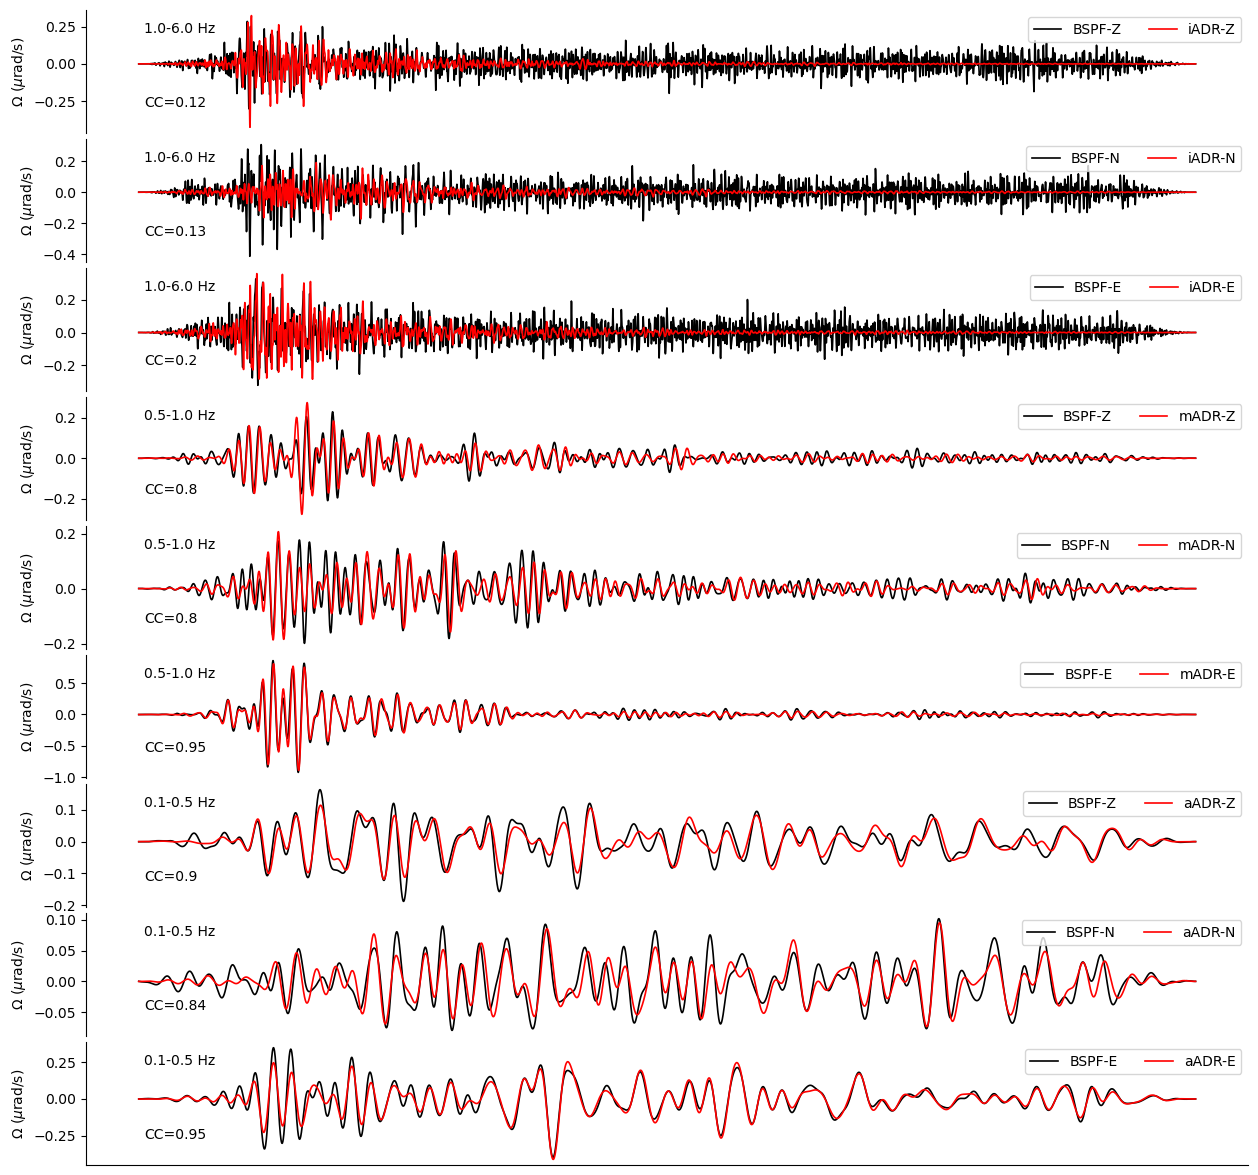

In [98]:
fig = __makeplot_waveform_comparison_all(st0);

fig.savefig(config['path_to_figs']+f"BSPF_M62_waveforms_all.png", format="png", dpi=200, bbox_inches='tight');

In [15]:
def __makeplot_waveform_comparison(bspf, adr, submask):

    from obspy.signal.cross_correlation import correlate

    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

    lw = 1.2
    font = 14

    ax[0].plot(bspf.select(channel="*Z")[0].times(), bspf.select(channel="*Z")[0].data, label="BSPF Z", color="k", lw=lw)
    ax[0].plot(adr.select(channel="*Z")[0].times(), adr.select(channel="*Z")[0].data, label="ADR Z", color="r", lw=lw)

    ax[1].plot(bspf.select(channel="*N")[0].times(), bspf.select(channel="*N")[0].data, label="BSPF N", color="k", lw=lw)
    ax[1].plot(adr.select(channel="*N")[0].times(), adr.select(channel="*N")[0].data, label="ADR N", color="r", lw=lw)

    ax[2].plot(bspf.select(channel="*E")[0].times(), bspf.select(channel="*E")[0].data, label="BSPF E", color="k", lw=lw)
    ax[2].plot(adr.select(channel="*E")[0].times(), adr.select(channel="*E")[0].data, label="ADR E", color="r", lw=lw)

    cc_Z = round(correlate(bspf.select(channel="*Z")[0].data, adr.select(channel="*Z")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 1)
    cc_N = round(correlate(bspf.select(channel="*N")[0].data, adr.select(channel="*N")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 1)
    cc_E = round(correlate(bspf.select(channel="*E")[0].data, adr.select(channel="*E")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 1)

    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        # ax[i].set_xscale("log")
        ax[i].set_ylabel("$\Omega$ (rad/s)")

    ax[2].set_xlabel("Time (s)")
    ax[0].set_title(f"{config['tbeg'].date} | {config['fmin']}-{config['fmax']} Hz | ADR {submask} | CC$_Z$ = {cc_Z} | CC$_N$ = {cc_N} | CC$_E$ = {cc_E}")

    plt.show();
    return fig

HJZ 1.8861227379661853e-07
HJN 9.772979103344085e-08
HJE 4.78691052869252e-07


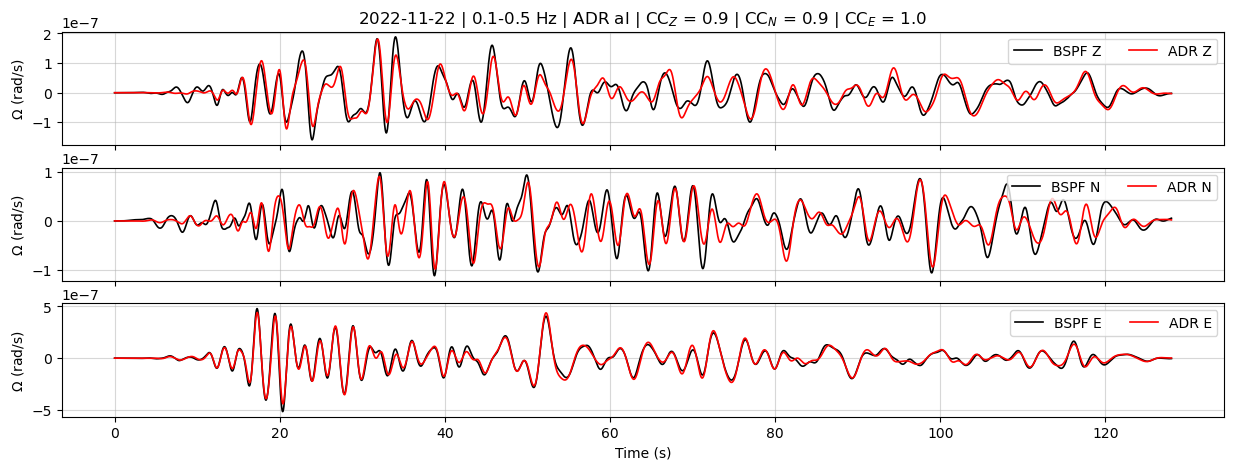

In [16]:
config['fmin'] = 0.1
config['fmax'] = 0.5

# config['fmin'] = 1.0
# config['fmax'] = 6.0

# config['fmin'] = 0.5
# config['fmax'] = 1.0

bspf = bspf0.copy()
bspf = bspf.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'])

adr = adr0.copy()
adr = adr.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax']);

pfo = pfo0.copy()
pfo = pfo.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'])

for tr in bspf:
    print(tr.stats.channel, max(tr.data))


fig = __makeplot_waveform_comparison(bspf, adr, submask)

fig.savefig(config['path_to_figs']+f"BSPF_M62_waveforms_{submask}.png", format="png", dpi=200, bbox_inches='tight');

In [17]:
abs(bspf[0].data).max()
abs(bspf[1].data).max()
abs(bspf[2].data).max()
bspf

5.437985825636164e-07

5.34747864082125e-07

1.4124963885257788e-06

3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-22T16:40:21.001000Z - 2022-11-22T16:42:29.001000Z | 40.0 Hz, 5121 samples
PY.BSPF..HJN | 2022-11-22T16:40:21.001000Z - 2022-11-22T16:42:29.001000Z | 40.0 Hz, 5121 samples
PY.BSPF..HJE | 2022-11-22T16:40:21.001000Z - 2022-11-22T16:42:29.001000Z | 40.0 Hz, 5121 samples

In [9]:
from functions.compute_cross_wavelet_transform import __compute_cross_wavelet_transform

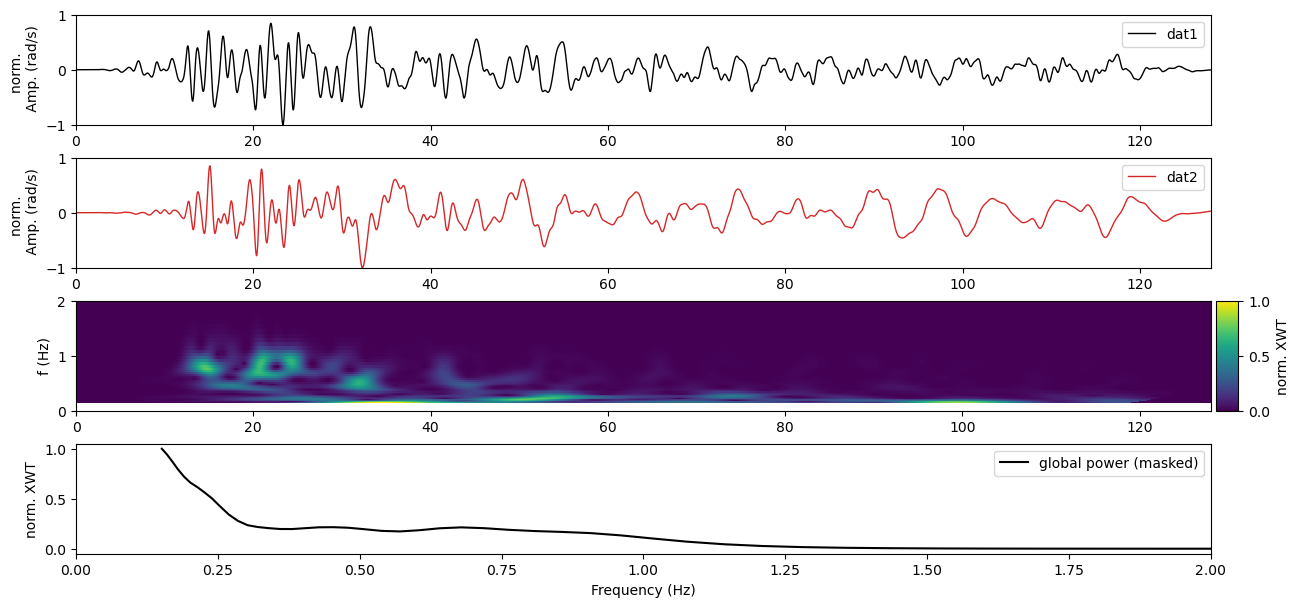

In [10]:
acc = st0.select(station="PFO*").copy().detrend("demean")
rot = st0.select(station="BSPF").copy().detrend("demean")
adr = st0.select(station="RPFO").copy().detrend("demean")

rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'])
adr.detrend("demean").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'])


comp = "Z"

out = __compute_cross_wavelet_transform(
                                    rot[0].times(),
                                    rot.select(channel=f"*{comp}")[0].data,
                                    adr.select(channel=f"*{comp}")[0].data,
                                    rot[0].stats.delta,
                                    xwt_threshold=0.,
                                    fmax_limit=config['fmax'],
                                    normalize=True,
                                    plot=True,
)

out['fig'].savefig(config['path_to_figs']+f"BSPF_M62_xwt_{comp}_{submask}.png", format="png", dpi=200, bbox_inches='tight');

## Backazimuth

In [41]:
from functions.compute_backazimuth import __compute_backazimuth

In [42]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

fmin, fmax = config['fmin'], config['fmax']

rot.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)
acc.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)


# acc.select(channel="*Z")[0].data *= -1
# rot.select(channel="*Z")[0].data *= -1
# rot.select(channel="*E")[0].data *= -1
# rot.select(channel="*N")[0].data *= -1

3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-22T16:40:21.001000Z - 2022-11-22T16:42:29.001000Z | 40.0 Hz, 5121 samples
PY.BSPF..HJN | 2022-11-22T16:40:21.001000Z - 2022-11-22T16:42:29.001000Z | 40.0 Hz, 5121 samples
PY.BSPF..HJE | 2022-11-22T16:40:21.001000Z - 2022-11-22T16:42:29.001000Z | 40.0 Hz, 5121 samples

3 Trace(s) in Stream:
II.PFO.10.BHZ | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples
II.PFO.10.BHN | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples
II.PFO.10.BHE | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples

In [43]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']

## specify window length for baz estimation in seconds
config['win_length_sec'] = 1/fmin

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1

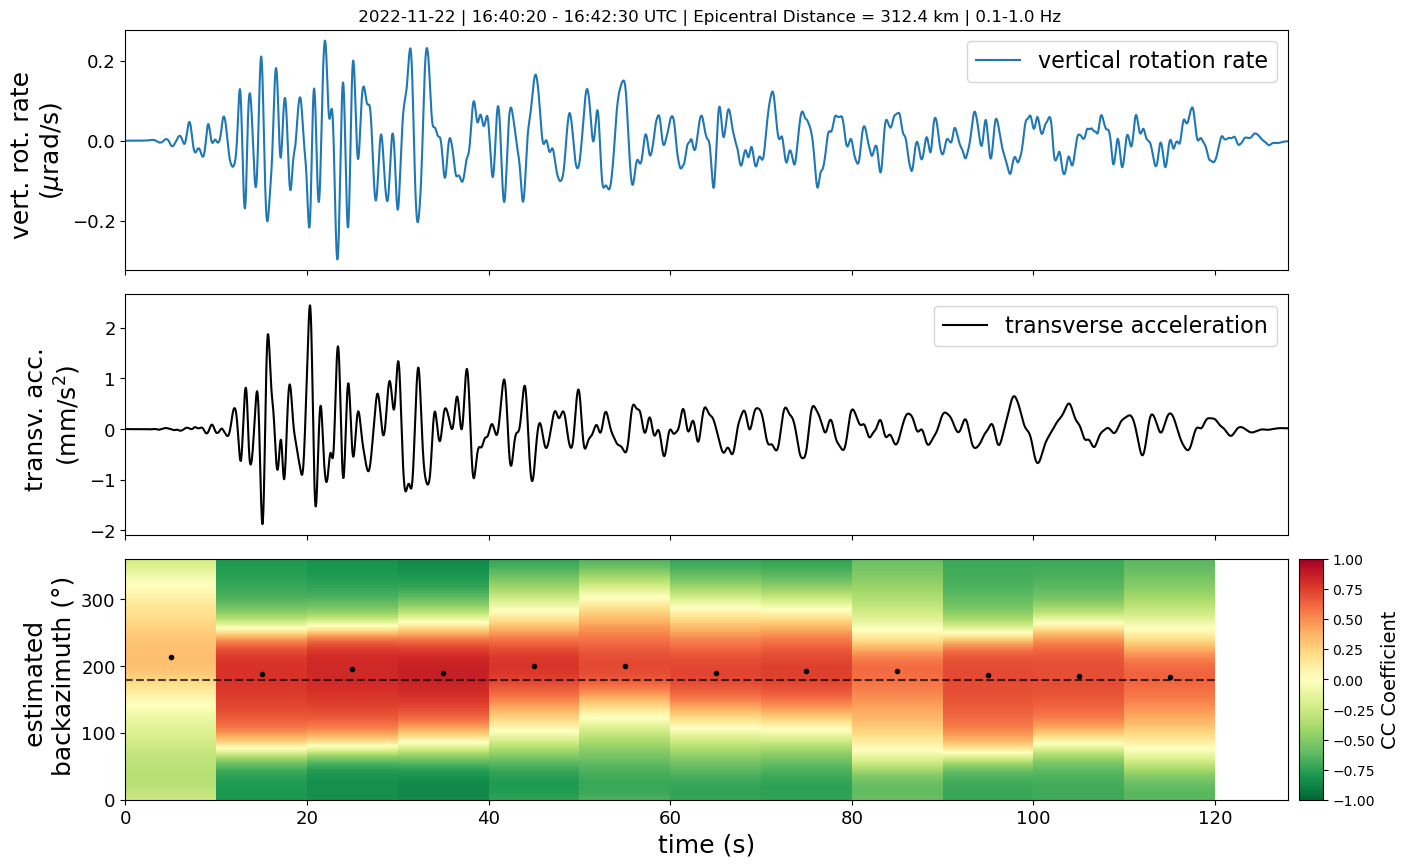

In [44]:
out = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='love',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
)

out['fig'].savefig(config['path_to_figs']+f"BSPF_M62_baz_love_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


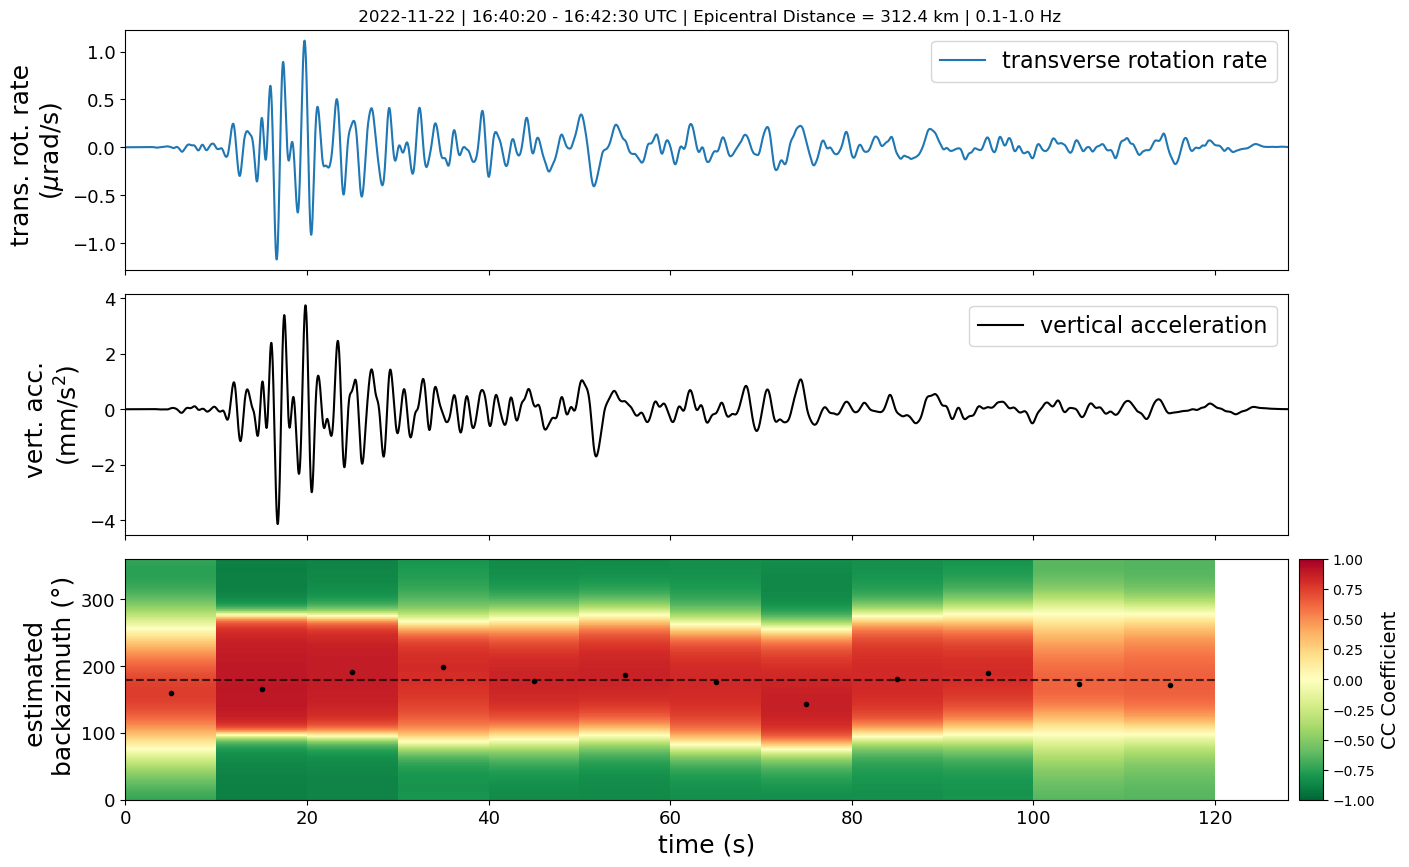

In [45]:
out = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='rayleigh',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
)

out['fig'].savefig(config['path_to_figs']+f"BSPF_M62_baz_rayleigh_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


In [46]:
from functions.get_theoretical_backazimuth import __get_theoretical_backazimuth

In [47]:
config['event'] = event

baz, az, dist = __get_theoretical_backazimuth(config['BSPF_lat'], config['BSPF_lon'], event_obj=event, fdsn_client='USGS')

In [48]:
from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent

In [49]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

fmin, fmax = 0.5, 2.0
# fmin, fmax = config['fmin'], config['fmax']


rot.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)
acc.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

# for tr in rot:
#     tr.data = np.roll(tr.data, -10)

# for tr in acc:
#     if "*Z" in tr.stats.channel:
#         tr.data *= -1

# rot.select(channel="*Z")[0].data *= -1
# rot.select(channel="*E")[0].data *= -1
# rot.select(channel="*N")[0].data *= -1

3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-22T16:40:21.001000Z - 2022-11-22T16:42:29.001000Z | 40.0 Hz, 5121 samples
PY.BSPF..HJN | 2022-11-22T16:40:21.001000Z - 2022-11-22T16:42:29.001000Z | 40.0 Hz, 5121 samples
PY.BSPF..HJE | 2022-11-22T16:40:21.001000Z - 2022-11-22T16:42:29.001000Z | 40.0 Hz, 5121 samples

3 Trace(s) in Stream:
II.PFO.10.BHZ | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples
II.PFO.10.BHN | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples
II.PFO.10.BHE | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples

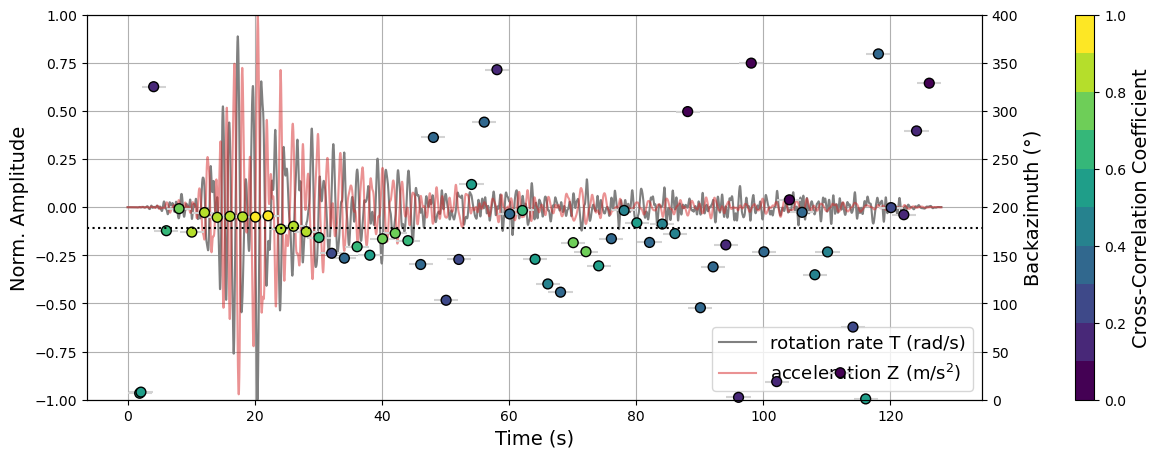

In [50]:
out = __compute_backazimuth_tangent(
                                    rot,
                                    acc,
                                    win_time_s=1/fmin,
                                    overlap=0.9,
                                    baz_theo=baz,
                                    cc_thres=0,
                                    plot=True,
                                    )

out['fig'].savefig(config['path_to_figs']+f"BSPF_M62_baz_tangent_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

## Compare Backazimuth Codes

In [51]:
# def __makeplot_baz_compare(rot, acc, cat_event, fmin, fmax, plot=False):

#     import matplotlib.pyplot as plt
#     from numpy import ones, linspace, histogram, concatenate, average, argmax, isnan, sqrt, cov

#     rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)
#     acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

#     config = {}

#     config['tbeg'] = rot[0].stats.starttime
#     config['tend'] = rot[0].stats.endtime

#     ## Eventtime
#     config['eventtime'] = obs.UTCDateTime(cat_event.origins[0].time)

#     ## specify coordinates of station
#     config['station_longitude'] =  -116.455439
#     config['station_latitude']  = 33.6106

#     ## specify window length for baz estimation in seconds
#     config['win_length_sec'] = 1/fmin

#     ## define an overlap for the windows in percent (50 -> 50%)
#     config['overlap'] = 50

#     ## specify steps for degrees of baz
#     config['step'] = 1


#     out1 = __compute_backazimuth(
#                                 acc,
#                                 rot,
#                                 config,
#                                 wave_type='rayleigh',
#                                 event=cat_event,
#                                 plot=False,
#                                 flim=(fmin, fmax),
#                                 show_details=False,
#     )

#     out2 = __compute_backazimuth(
#                                 acc,
#                                 rot,
#                                 config,
#                                 wave_type='love',
#                                 event=cat_event,
#                                 plot=False,
#                                 flim=(fmin, fmax),
#                                 show_details=False,
#     )

#     out3 = __compute_backazimuth_tangent(
#                                         rot,
#                                         acc,
#                                         win_time_s= config['win_length_sec'],
#                                         overlap=config['overlap']/100,
#                                         baz_theo=out2['baz_theo'],
#                                         cc_thres=0,
#                                         plot=False,
#     )


#     if plot:

#         NN = 6
#         rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
#         trans_scaling, trans_unit = 1e3, r"mm/s$^2$"

#         font = 12

#         fig, ax = plt.subplots(NN, 1, figsize=(15,10), sharex=True)

#         plt.subplots_adjust(hspace=0.2)

#         hz = acc.select(channel="*HZ")[0]
#         hn = acc.select(channel="*HN")[0]
#         he = acc.select(channel="*HE")[0]

#         jz = rot.select(channel="*JZ")[0]
#         jn = rot.select(channel="*JN")[0]
#         je = rot.select(channel="*JE")[0]

#         t1, t2 = hz.times().min(), hz.times().max()

#         ax[0].plot(hz.times(), hz.data*trans_scaling, 'black', label=f"XPFO.Z")
#         ax[1].plot(hn.times(), hn.data*trans_scaling, 'black', label=f"XPFO.N")
#         ax[2].plot(he.times(), he.data*trans_scaling, 'black', label=f"XPFO.E")

#         ax[0].set_ylim(-max(abs(hz.data*trans_scaling)), max(abs(hz.data*trans_scaling)))
#         ax[1].set_ylim(-max(abs(hn.data*trans_scaling)), max(abs(hn.data*trans_scaling)))
#         ax[2].set_ylim(-max(abs(he.data*trans_scaling)), max(abs(he.data*trans_scaling)))

#         ax00 = ax[0].twinx()
#         ax00.plot(jz.times(), jz.data*rot_scaling, 'darkred', label=r"BSPF.Z")

#         ax11 = ax[1].twinx()
#         ax11.plot(jn.times(), jn.data*rot_scaling, 'darkred', label=r"BSPF.N")

#         ax22 = ax[2].twinx()
#         ax22.plot(je.times(), je.data*rot_scaling, 'darkred', label=r"BSPF.E")

#         ax00.set_ylim(-max(abs(jz.data*rot_scaling)), max(abs(jz.data*rot_scaling)))
#         ax11.set_ylim(-max(abs(jn.data*rot_scaling)), max(abs(jn.data*rot_scaling)))
#         ax22.set_ylim(-max(abs(je.data*rot_scaling)), max(abs(je.data*rot_scaling)))

#         cmap = plt.get_cmap("viridis", 10)

#         ca3 = ax[3].scatter(out1['cc_max_t'], out1['cc_max_y'], c=out1['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
#         ax[3].plot([t1, t2], ones(2)*out1['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)

#         ca4 = ax[4].scatter(out2['cc_max_t'], out2['cc_max_y'], c=out2['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
#         ax[4].plot([t1, t2], ones(2)*out2['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)

#         ca5 = ax[5].scatter(out3['t_win_center'], out3['baz_est'], c=out3['ccoef'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
#         ax[5].plot([t1, t2], ones(2)*out3['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)

#         cax3 = ax[3].inset_axes([1.01, 0., 0.02, 1])
#         cb3 = plt.colorbar(ca3, ax=ax[3], cax=cax3)
#         cb3.set_label("CC-Coeff.", fontsize=font)

#         cax4 = ax[4].inset_axes([1.01, 0., 0.02, 1])
#         cb4 = plt.colorbar(ca4, ax=ax[4], cax=cax4)
#         cb4.set_label("CC-Coeff.", fontsize=font)

#         cax5 = ax[5].inset_axes([1.01, 0., 0.02, 1])
#         cb5 = plt.colorbar(ca5, ax=ax[5], cax=cax5)
#         cb5.set_label("CC-Coeff.", fontsize=font)

#         ax[3].set_ylabel(f"Rayleigh Baz.(°)")
#         ax[4].set_ylabel(f"Love Baz.(°)")
#         ax[5].set_ylabel(f"CoVar. Baz.(°)")


#         ax[0].set_yticks(linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].get_yticks())))
#         ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))

#         ax[1].set_yticks(linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
#         ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

#         ax[2].set_yticks(linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
#         ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))

#         for i in [0,1,2]:
#             ax[i].grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
#             ax[i].legend(loc=1)
#             ax[i].set_ylabel(f"a ({trans_unit})")

#         for i in [3,4,5]:
#             ax[i].set_ylim(-5, 365)
#             ax[i].set_yticks(range(0,360+60,60))
#             ax[i].grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
#             # ax[i].set_ylabel(f"Baz.(°)")

#         for aaxx in [ax00, ax11, ax22]:
#             aaxx.tick_params(axis='y', colors="darkred")
#             aaxx.set_ylabel(f"$\omega$ ({rot_unit})", color="darkred")
#             aaxx.legend(loc=4)

#         ax[0].set_title(f" {config['tbeg'].date}  {str(config['tbeg'].time).split('.')[0]}-{str(config['tend'].time).split('.')[0]} UTC | f = {fmin}-{fmax} Hz | T = {config['win_length_sec']} s | {config['overlap']} % ")

#         plt.show();



#     ## compute statistics
#     deltaa = 5
#     angles = np.arange(0, 365, deltaa)


#     ## Rayleigh
#     hist = histogram(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out1['cc_max'], density=True)

#     baz_rayleigh_mean = round(average(out1['cc_max_y'][~isnan(out1['cc_max_y'])], weights=out1['cc_max'][~isnan(out1['cc_max'])]), 0)
#     baz_rayleigh_cov = sqrt(cov(out1['cc_max_y'][~isnan(out1['cc_max_y'])], aweights=out1['cc_max'][~isnan(out1['cc_max'])]))

#     baz_rayleigh_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center

#     ## Love
#     hist = histogram(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out2['cc_max'], density=True)

#     baz_love_mean = round(average(out2['cc_max_y'][~isnan(out2['cc_max_y'])], weights=out2['cc_max'][~isnan(out2['cc_max'])]), 0)
#     baz_love_cov = sqrt(cov(out2['cc_max_y'][~isnan(out2['cc_max_y'])], aweights=out2['cc_max'][~isnan(out2['cc_max'])]))

#     baz_love_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center

#     ## Tangent
#     hist = histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out3['ccoef'], density=True)

#     baz_tangent_mean = round(average(out3['baz_est'][~isnan(out3['baz_est'])], weights=out3['ccoef'][~isnan(out3['ccoef'])]), 0)
#     baz_tangent_cov = sqrt(cov(out3['baz_est'][~isnan(out3['baz_est'])], aweights=out3['ccoef'][~isnan(out3['ccoef'])]))

#     baz_tangent_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center


#     out = {}
#     out['baz_theo'] = round(out2['baz_theo'], 0)
#     out['baz_angles'] = angles
#     out['baz_tangent_max'] = baz_tangent_max
#     out['baz_tangent_mean'] = baz_tangent_mean
#     out['baz_tangent_cov'] = baz_tangent_cov
#     out['baz_rayleigh_max'] = baz_rayleigh_max
#     out['baz_rayleigh_mean'] = baz_rayleigh_mean
#     out['baz_rayleigh_cov'] = baz_rayleigh_cov
#     out['baz_love_max'] = baz_love_max
#     out['baz_love_mean'] = baz_love_mean
#     out['baz_love_cov'] = baz_love_cov


#     if plot:
#         out['fig'] = fig

#     return out

In [52]:
from functions.compare_backazimuth_codes import __compare_backazimuth_codes

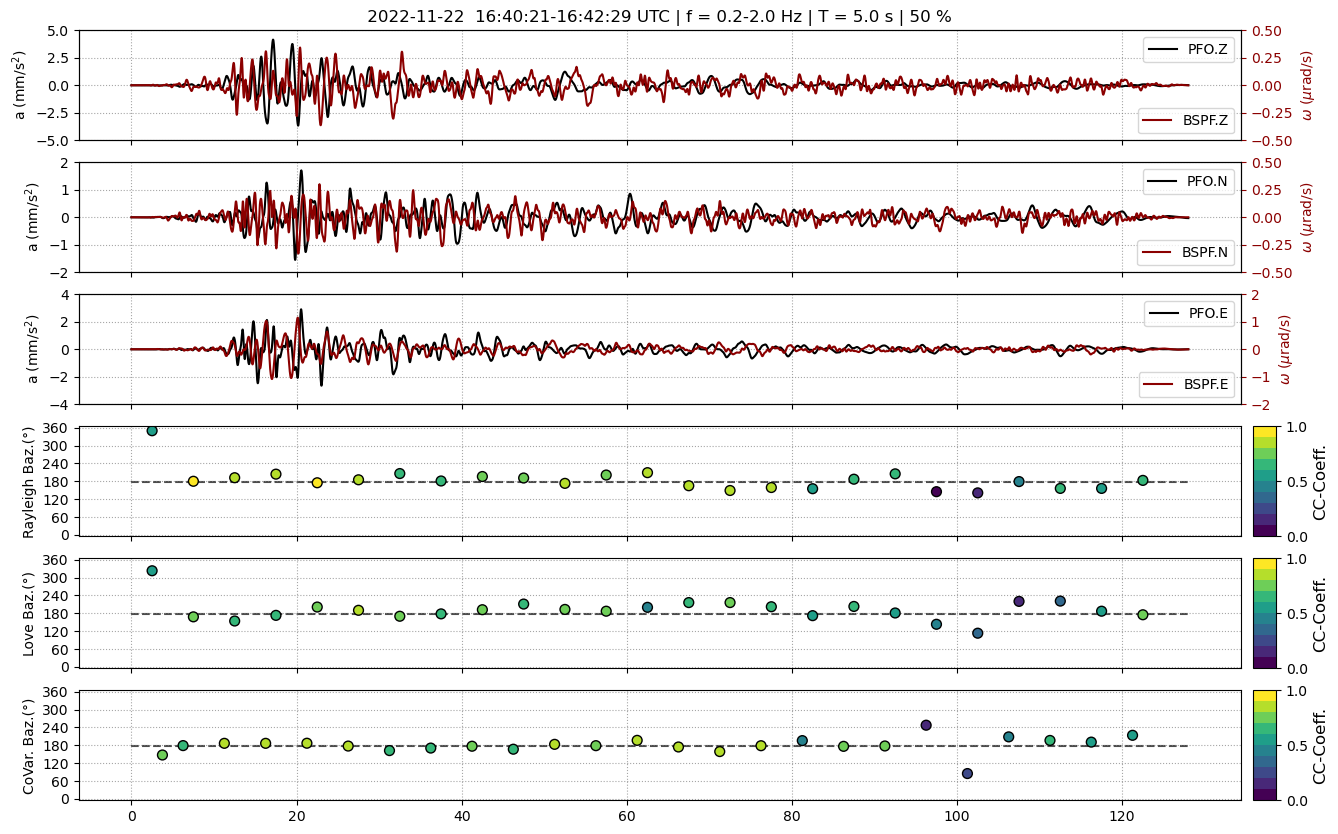

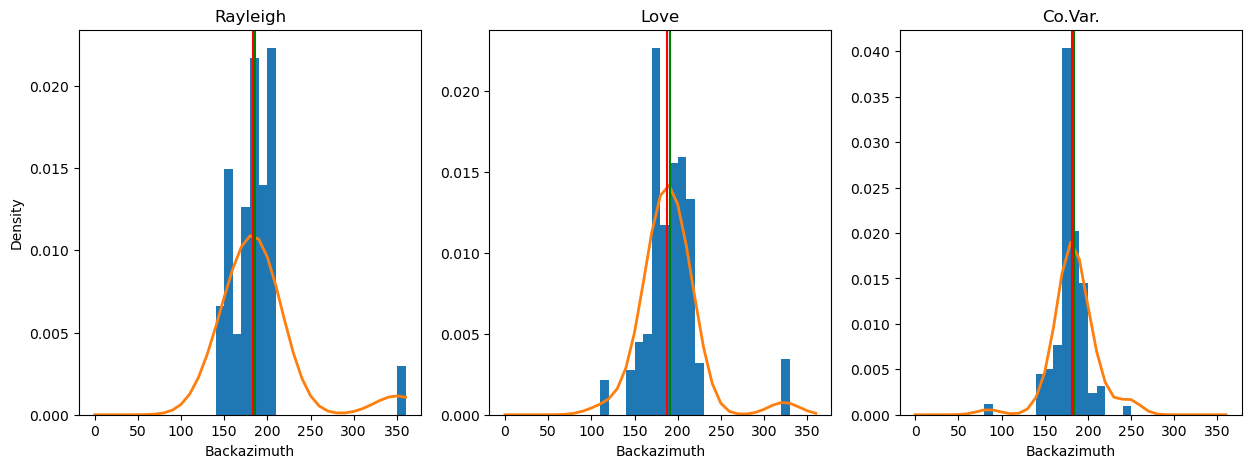

In [53]:
st = st0.copy();

acc = st.select(station="PFO*");
rot = st.select(station="BSPF");
# rot = st.select(station="RPFO", location="in");
# rot = st.select(station="RPFO", location="mi");
# rot = st.select(station="RPFO", location="al");

# for tr in rot:
#     tr.data = np.roll(tr.data, -10)


# fmin, fmax = config['fmin'], config['fmax']
fmin, fmax = 0.2, 2.0

out = __compare_backazimuth_codes(rot, acc, event, fmin, fmax, plot=True);

out['fig1'].savefig(config['path_to_figs']+f"BSPF_M62_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05);
out['fig2'].savefig(config['path_to_figs']+f"BSPF_M62_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}_hist.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

## Compare backazimuth estimate for ADR, BSPF and Beamforming

In [54]:
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

In [55]:
st = st0.copy();

acc = st.select(station="PFO*").copy();

## ____________________
## direct rotation
rot = st.select(station="BSPF").copy();
out_bspf_i = __compare_backazimuth_codes(rot, acc, event, fmin=1.0, fmax=12.0, plot=False);

rot = st.select(station="BSPF").copy();
out_bspf_m = __compare_backazimuth_codes(rot, acc, event, fmin=0.5, fmax=2.0, plot=False);

rot = st.select(station="BSPF").copy();
out_bspf_a = __compare_backazimuth_codes(rot, acc, event, fmin=0.3, fmax=1.0, plot=False);

# rot = st.select(station="BSPF").copy();
# out_bspf_o = __makeplot_baz_compare(rot, acc, event, fmin=0.9, fmax=2.0, plot=False);

## ____________________
## adr rotation
rot = st.select(station="RPFO", location="in").copy();
out_adr_i = __compare_backazimuth_codes(rot, acc, event, fmin=1.0, fmax=12.0, plot=False);

rot = st.select(station="RPFO", location="mi").copy();
out_adr_m = __compare_backazimuth_codes(rot, acc, event, fmin=0.5, fmax=2.0, plot=False);

rot = st.select(station="RPFO", location="al").copy();
out_adr_a = __compare_backazimuth_codes(rot, acc, event, fmin=0.3, fmax=1.0, plot=False);

# rot = st.select(station="RPFO", location="al").copy();
# out_adr_o = __makeplot_baz_compare(rot, acc, event, fmin=0.9, fmax=2.0, plot=False);

## ____________________
## array beamforming
out_bf_i = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=1.0, fmax=12.0, component="Z", submask="inner", plot=False)
out_bf_m = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.5, fmax=2.0, component="Z", submask="mid", plot=False)
out_bf_a = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.3, fmax=1.0, component="Z", submask="all", plot=False)
# out_bf_o = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.9, fmax=2.0, component="Z", submask="inner", plot=False)


 -> obtained: 3 of 3 stations!

 -> Runtime: 0.27 minutes
 -> obtained: 6 of 6 stations!

 -> Runtime: 0.45 minutes
 -> obtained: 11 of 11 stations!

 -> Runtime: 0.78 minutes


In [65]:
def __makeplot_comparison():

    labels = ["iBSPF", "iADR", "iBF", "mBSPF", "mADR", "mBF", "aBSPF", "aADR", "aBF"]

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    font = 12

    ax.axhline(out_bspf_i['baz_theo'], color="k", ls="--", label="theo. Baz.")
    ax.fill_between([-0.3, 4.0], out_bspf_i['baz_theo']-10, out_bspf_i['baz_theo']+10, color="yellow", alpha=0.5, label="theo. Baz. +- 10°")


    for j, out in enumerate([out_adr_i, out_adr_m, out_adr_a]):

        ax.errorbar(j-0.02, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.02, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j-0.02, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.02, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")

        ## plot only for legend icon

        if j == 0:
            ax.scatter(j+0.4, out_bf_i['baz_bf_max'], color="tab:orange", zorder=2, label="beamforming", edgecolors="k")
            ax.legend(loc=1)


    for j, out in enumerate([out_bspf_i, out_bspf_m, out_bspf_a]):

        ax.errorbar(j+0.18, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j+0.2, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.22, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j+0.18, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j+0.2, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.22, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")


    for j, out in enumerate([out_bf_i, out_bf_m, out_bf_a]):

        ax.errorbar(j+0.4, out['baz_bf_max'], yerr=out['baz_bf_std'], color="tab:orange", zorder=2)
        ax.scatter(j+0.4, out['baz_bf_max'], color="tab:orange", zorder=2, label="", edgecolors="k")



    ax.set_xticks([0,0.2,0.4,1,1.2,1.4,2,2.2,2.4], labels=labels, fontsize=font-1)

    ax.grid(axis="y", ls=":", color="k", alpha=0.5, zorder=0)

    ax.text(0, 360+10, "1.0 - 12.0 Hz", fontsize=font-1)
    ax.text(1, 360+10, "0.5 - 3.0 Hz", fontsize=font-1)
    ax.text(2, 360+10, "0.3 - 1.0 Hz", fontsize=font-1)
    ax.text(3, 360+10, "0.8 - 2.0 Hz", fontsize=font-1)


    ax.set_ylabel("Backazimuth (°)", fontsize=font)

    ax.set_xlim(-0.3, 3.0)
    ax.set_ylim(0, 360)

    plt.show();
    return fig

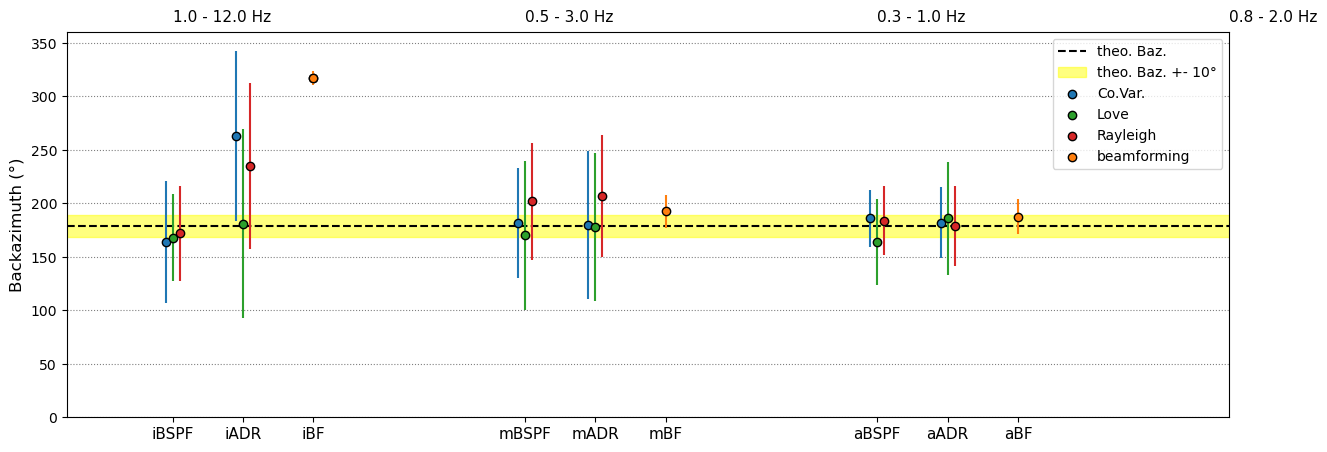

In [66]:
fig = __makeplot_comparison()

fig.savefig(config['path_to_figs']+f"BSPF_M62_baz_comparison_overview.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

## Cross Spectral Density

In [67]:
def __makeplotStream_csd2(st0, config):

    from scipy import fftpack
    from matplotlib.gridspec import GridSpec
    from scipy.signal import csd
    from numpy import array, log10
    
    import matplotlib.pyplot as plt

    st = st0.copy()
    
    NN = 5
    rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
    
#     rot_scaling, rot_unit = 1, r"nrad/s"
#     trans_scaling, trans_unit = 1, r"$\mu$m/s"

    colors2 = ['darkred', 'darkgreen', 'magenta', 'tab:green', 'red', 'lightgreen']
#     colors2 = ['crimson', 'darkblue', 'red', '#3776ab', 'magenta', 'indigo']

    fig = plt.figure(figsize=(15,14))
    
    gs = GridSpec(NN, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    ax7 = fig.add_subplot(gs[3:, :])
    
    
    font = 14
    
    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

#     st.normalize()
    
    st.sort(keys=['channel'], reverse=True)
        
    bspf_all_data, bspf_inner_data, adr_all_data, adr_inner_data = [],[],[],[] 
    names, ffs, csds, ffs2, csds2 = [], [], [], [], []
    for comp in ["Z", "N", "E"]:
                
        tmp = st.select(channel=f"*{comp}")
        print(tmp)

        bspf_inner = tmp[0].copy()
        bspf_inner.detrend("linear")
        bspf_inner.taper(0.1)
        bspf_inner.filter("bandpass", freqmin=5, freqmax=15, corners=4, zerophase=True)
        bspf_inner.normalize()
        
        adr_inner = tmp[1].copy()
        adr_inner.detrend("linear")
        adr_inner.taper(0.1)
        adr_inner.filter("bandpass", freqmin=5, freqmax=15, corners=4, zerophase=True)
        adr_inner.normalize()
        
        nseg = int(5*tmp[0].stats.sampling_rate)
        
        ff, Pxy = csd(  
                        bspf_inner.data,
                        adr_inner.data,
                        fs=bspf_inner.stats.sampling_rate,
                        nperseg=nseg,
                        window='hann',
                        noverlap=int(0.5*nseg),
                        nfft=None,
                        detrend='constant',
                        return_onesided=True,
                        scaling='density',
                        axis=-1,
                        average='mean'
                    )
        
        names.append(f"{tmp[0].stats.channel}"+r"$_{inner}$")
        ffs.append(ff)
        csds.append(Pxy)

        adr_inner_data.append(adr_inner.data)
        bspf_inner_data.append(bspf_inner.data)
        
        ## _____________________________________
        
        bspf_all = tmp[0].copy()
        bspf_all.detrend("linear")        
        bspf_all.taper(0.1)
        bspf_all.filter("bandpass", freqmin=0.1, freqmax=1., corners=4, zerophase=True)
        bspf_all.normalize()

        adr_all = tmp[2].copy()
        adr_all.detrend("linear")
        adr_all.taper(0.1)
        adr_all.filter("bandpass", freqmin=0.1, freqmax=1., corners=4, zerophase=True)
        adr_all.normalize()        
            
        nseg = int(20*tmp[0].stats.sampling_rate)
        
        ff2, Pxy2 = csd(  
                        bspf_all.data*rot_scaling,
                        adr_all.data*rot_scaling,
                        fs=bspf_all.stats.sampling_rate,
                        nperseg=nseg,
                        window='hann',
                        noverlap=int(0.5*nseg),
                        nfft=None,
                        detrend='constant',
                        return_onesided=True,
                        scaling='spectrum',
                        axis=-1,
                        average='mean'
                    )
        
        names.append(f"{tmp[0].stats.channel}"+r"$_{all}$")
        
        ffs.append(ff2)
        csds.append(Pxy2)
        
        adr_all_data.append(adr_all.data)
        bspf_all_data.append(bspf_all.data)
        
    hz = st.select(channel="B*Z")[0]
    hn = st.select(channel="B*N")[0]
    he = st.select(channel="B*E")[0]

    jz = st.select(channel="HJZ")[0]
    jn = st.select(channel="HJN")[0]
    je = st.select(channel="HJE")[0]

    ax1.plot(hz.times(), bspf_all_data[0], 'black', label=f"BSPF.Z")
    ax2.plot(hn.times(), bspf_all_data[1], 'black', label=f"BSPF.N")
    ax3.plot(he.times(), bspf_all_data[2], 'black', label=f"BSPF.E")
    ax1.plot(hz.times(), adr_all_data[0], 'darkred', label=r"ADR$_{all}$.Z")
    ax2.plot(hn.times(), adr_all_data[1], 'darkred', label=r"ADR$_{all}$.N")
    ax3.plot(he.times(), adr_all_data[2], 'darkred', label=r"ADR$_{all}$.E")

    ax4.plot(jz.times(), bspf_inner_data[0], 'black', label=f"BSPF.Z")
    ax5.plot(jn.times(), bspf_inner_data[1], 'black', label=f"BSPF.N")
    ax6.plot(je.times(), bspf_inner_data[2], 'black', label=f"BSPF.E")
    ax4.plot(jz.times(), adr_inner_data[0], 'darkred', label=r"ADR$_{inner}$.Z")
    ax5.plot(jn.times(), adr_inner_data[1], 'darkred', label=r"ADR$_{inner}$.N")
    ax6.plot(je.times(), adr_inner_data[2], 'darkred', label=r"ADR$_{inner}$.E")


    for ii, (ff, cc, name) in enumerate(zip(ffs, csds, names)):
#         ax7.plot(ff, 20*log10(abs(cc)), label=name[2:], alpha=0.6, color=colors2[ii])
        if "all" in name:
            ax7.plot(ff, abs(cc), label=name[2:], alpha=0.6, color=colors2[ii])
        elif "inner" in name:       
            if "Z" in name:
                ax8 = ax7.twinx()
            ax8.plot(ff, abs(cc), label=name[2:], alpha=0.6, color=colors2[ii])
            

#     ax7.set_yscale("log")
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.95, 1.10), ncol=2)
        ax.set_ylabel(f"$\omega$ ({rot_unit})", fontsize=font)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[]) 
            ax.tick_params(bottom=False)  
    
    ax7.set_xscale("log")   
    ax7.grid(which="both", ls=":", alpha=0.7, color="grey")
    ax7.legend(fontsize=font-2, ncol=3, loc=2)
    ax7.set_xlim(0.1, 20)
    ax7.set_xlabel("Frequency (Hz)", fontsize=font)
    sqrthz=r"$\sqrt{Hz}$"
#     ax7.set_ylabel(f"Cross Spectral Density \n (dB rel. to 1 nrad$^2$/s$^2$/Hz)", fontsize=font)
    ax7.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrthz}')", fontsize=font)
    
    
    ax8.legend(fontsize=font-2, ncol=3, loc=1)
    ax8.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrthz}')", fontsize=font, color="tab:red")
    ax8.tick_params(axis='y', colors='tab:red')
    
    ax3.set_xlabel("Time (s)", fontsize=font)
    ax6.set_xlabel("Time (s)", fontsize=font)


    bbox = list(ax7.get_position().bounds)
    bbox[3] = .85*bbox[3] # Reduce the height of the axis a bit.
    ax7.set_position(bbox)
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6, ax7, ax8]:
        ax.tick_params(axis="y", labelsize=font-2)
        ax.tick_params(axis="x", labelsize=font-2)
            
#     axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    return fig

5 Trace(s) in Stream:
PY.BSPF..HJZ   | 2022-11-22T16:40:21.001000Z - 2022-11-22T16:42:29.001000Z | 40.0 Hz, 5121 samples
II.RPFO.in.BJZ | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples
II.RPFO.mi.BJZ | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples
II.RPFO.al.BJZ | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples
II.PFO.10.BHZ  | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples
5 Trace(s) in Stream:
PY.BSPF..HJN   | 2022-11-22T16:40:21.001000Z - 2022-11-22T16:42:29.001000Z | 40.0 Hz, 5121 samples
II.RPFO.in.BJN | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples
II.RPFO.mi.BJN | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples
II.RPFO.al.BJN | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples
II.PFO.10.BHN  | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:2

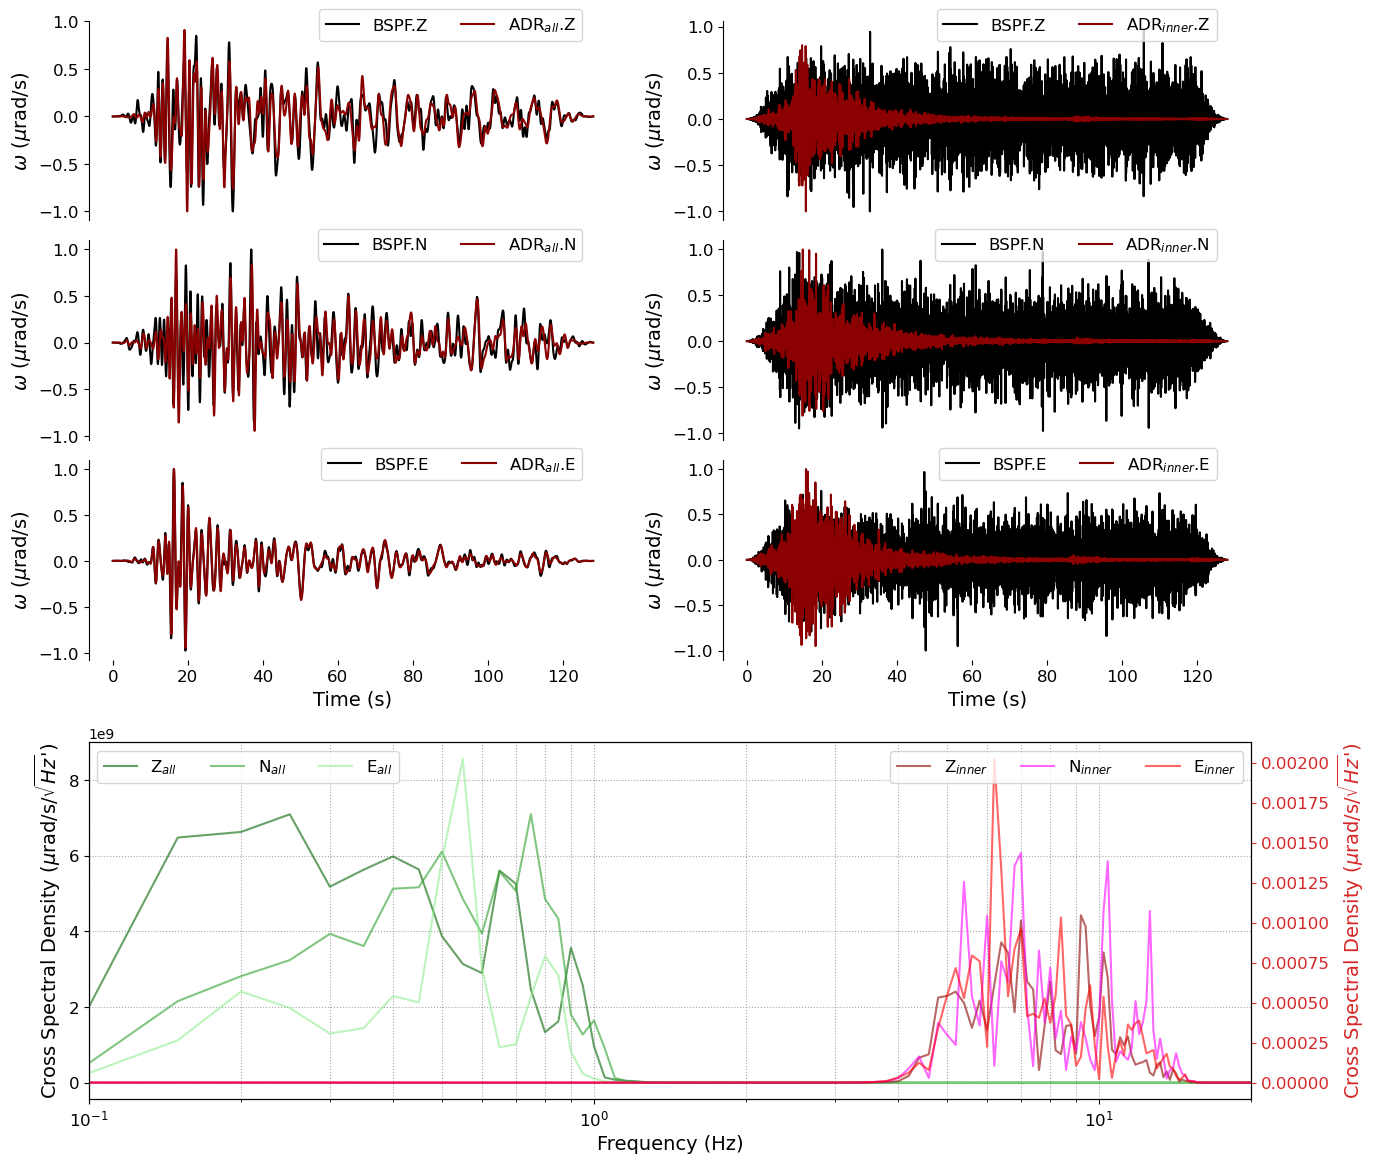

In [68]:
fig = __makeplotStream_csd2(st0, config);

fig.savefig(config['path_to_figs']+f"BSPF_M62_baz_csd.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

In [159]:
from functions.makeplotStream_cwt import __makeplotStream_cwt

In [161]:
# __makeplotStream_cwt(st0, config, fscale=None);

## Coherence in Octaves

In [218]:
from functions.makeplot_coherence_octaves import __coherence_in_octaves

In [219]:
# def __coherence_in_octaves(st_in, fmin, fmax, normalize=False, plot=True):

#     from matplotlib.gridspec import GridSpec
#     from numpy import arange, mean, nan, nanmax
#     from pandas import DataFrame
#     from functions.get_octave_bands import __get_octave_bands
#     from scipy.signal import coherence

#     flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="one-third-octave")
#     # flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="octave")

#     fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

#     colors = {"Z":"tab:red", "N":"tab:green", "E":"blue"}

#     ## _____________________

# #     ddf = 3
# #     fcenter = arange(fmin+ddf, fmax-ddf, 1)
# #     fbands = [(fc - ddf, fc + ddf) for fc in fcenter]

#     out = {}

#     if plot:
#         NN = 5
#         font = 12
#         rot_scale, rot_unit, omega, sqrt_hz = 1e6, r"$\mu$rad/s" , r"$\Omega$", r"$\sqrt{Hz}$"

#         fmin_i, fmax_i = 1.0, 10.0 ## 0.16, 16.5
#         fmin_a, fmax_a = 0.1, 1.0  ## 0.02, 1.3


#         fig = plt.figure(figsize=(15,14))

#         gs = GridSpec(NN, 2, figure=fig)

#         ax1 = fig.add_subplot(gs[0, :-1])
#         ax2 = fig.add_subplot(gs[1, :-1])
#         ax3 = fig.add_subplot(gs[2, :-1])

#         ax4 = fig.add_subplot(gs[0, 1:])
#         ax5 = fig.add_subplot(gs[1, 1:])
#         ax6 = fig.add_subplot(gs[2, 1:])

#         ax7 = fig.add_subplot(gs[3:, :])

#         plt.subplots_adjust(hspace=0.2)



#     for ii, comp in enumerate(["Z", "N", "E"]):

#         tr0 = st_in.select(station="BSPF", channel=f'*{comp}').copy()[0]
#         tr1 = st_in.select(station="BSPF", channel=f'*{comp}').copy()[0]
#         tr2 = st_in.select(station="RPFO", location="in", channel=f'*{comp}').copy()[0]
#         tr3 = st_in.select(station="RPFO", location="al", channel=f'*{comp}').copy()[0]

#         tr0 = tr0.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=4, zerophase=True)
#         tr1 = tr1.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=4, zerophase=True)
#         tr2 = tr2.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=4, zerophase=True)
#         tr3 = tr3.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=4, zerophase=True)

#         if normalize:
#             tr0 = tr0.normalize()
#             tr1 = tr1.normalize()
#             tr2 = tr2.normalize()
#             tr3 = tr3.normalize()
#             rot_scale, rot_unit = 1, r"rad/s"

#         co2, co3 = [], []
#         for nn, (fl, fu) in enumerate(fbands):
#             s0, s1, s2, s3 = tr0.copy(), tr1.copy(), tr2.copy(), tr3.copy()

#             df = s1.stats.sampling_rate

#             tseg = 1/fl # 1/fcenter[nn]
#             nseg = int(df*tseg) if int(df*tseg) < len(s1.data) else len(s1.data)
#             nover = int(0.5*nseg)

#             ff2, coh2 = coherence(s0.data, s2.data, fs=df, window='hann', nperseg=nseg, noverlap=nover)
#             ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann', nperseg=nseg, noverlap=nover)

# #             ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann')
# #             ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann')

#             for i in range(len(ff2)):
#                 if ff2[i] <= fl or ff2[i] >= fu:
#                     coh2[i], coh3[i] = nan, nan

#             plt.semilogx(ff2, coh2)

#             co2.append(nanmax(coh2))
#             co3.append(nanmax(coh3))

#         if plot:

#             if comp == "Z":
#                 ax1.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
#                 ax1.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

#                 ax4.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
#                 ax4.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

#             elif comp == "N":
#                 ax2.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
#                 ax2.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

#                 ax5.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
#                 ax5.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

#             elif comp == "E":
#                 ax3.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
#                 ax3.plot(tr2.times(), tr2.data*rot_scale,color=colors[comp], label=f"ADR-{comp}")

#                 ax6.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
#                 ax6.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

#             for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
#                 ax.legend(loc=1, ncol=2)
#                 ax.set_ylabel(f"{omega} ({rot_unit})", fontsize=font)

#             ax7.scatter(fcenter, co2, s=50, marker="s", label="BSPF - RPFO_inner", zorder=2, color="w", edgecolors=colors[comp])
#             ax7.plot(fcenter, co2, ls="-", color=colors[comp])

#             ax7.scatter(fcenter, co3, s=50, label="BSPF - PRFO_all", zorder=2, color="w", edgecolors=colors[comp])
#             ax7.plot(fcenter, co3, ls=":", color=colors[comp])

#             ax7.legend(loc=4, ncol=3)

#             ax7.set_xscale("log")
#             ax7.grid(ls="--",zorder=0, alpha=.5, which="both")

#             ax7.set_xlabel("Frequency (Hz)", fontsize=font)
#             # ax7.set_ylabel(f"Coherence ({rot_unit}/{sqrt_hz})", fontsize=font)
#             ax7.set_ylabel(f"max. coherence per one-third-octave", fontsize=font)

#             ax1.set_title(f"PRFO inner ({fmin_i} - {fmax_i} Hz)", fontsize=font)
#             ax4.set_title(f"PRFO all ({fmin_a} - {fmax_a} Hz)", fontsize=font)



#         ## prepare output
#         out[f'{comp}_in_fc'] = fcenter
#         out[f'{comp}_in_co']  = co2
#         out[f'{comp}_al_fc'] = fcenter
#         out[f'{comp}_al_co']  = co3

#     if plot:
#         out['fig'] = fig
#         plt.show();


#     return out

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


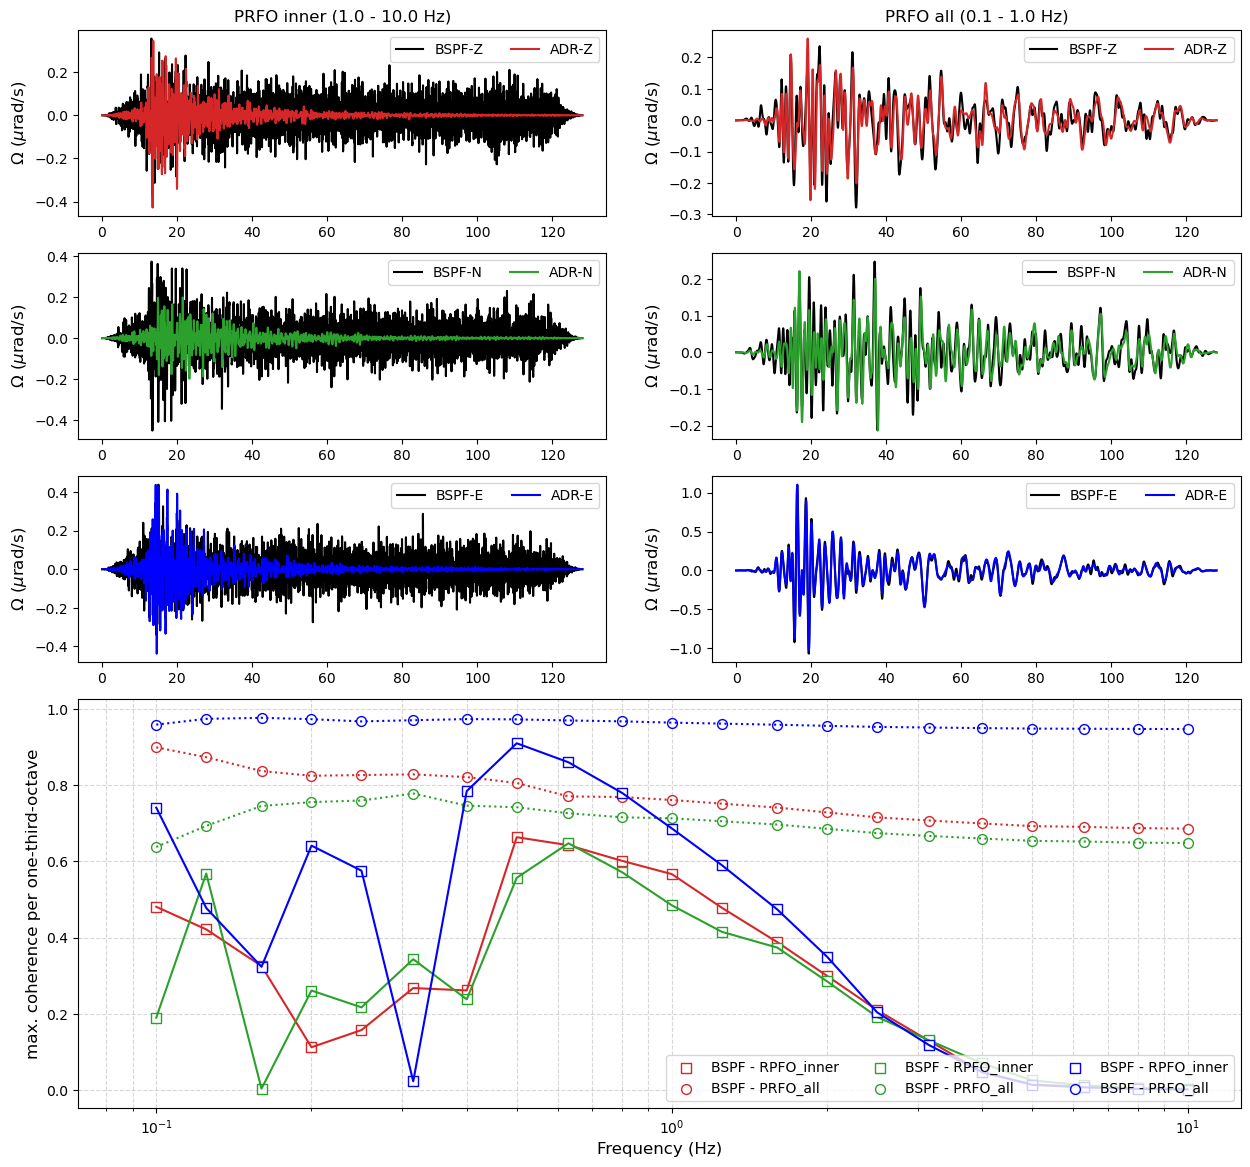

In [217]:
out_coh = __coherence_in_octaves(st0, fmin, fmax, normalize=False, plot=True)

out_coh['fig'].savefig(config['path_to_figs']+f"BSPF_M62_coherence.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

## Phase Velocity

In [102]:
from functions.compute_velocity_from_amplitude_ratio import __compute_velocity_from_amplitude_ratio

In [103]:
# %load functions/compute_velocity_from_amplitude_ratio.py
#!/bin/python3

def __compute_velocity_from_amplitude_ratio(rot0, acc0, baz=None, mode="love", win_time_s=2.0, cc_thres=0.8, overlap=0.5, flim=(None,None), plot=False):

    from scipy.stats import pearsonr
    from numpy import zeros, nan, ones, nanmean, array, nanmax, linspace, std
    from scipy import odr
    from obspy.signal.rotate import rotate_ne_rt
    from obspy.signal.cross_correlation import correlate
    from functions.compute_linear_regression import __compute_linear_regression
    import matplotlib.pyplot as plt

    npts = rot0[0].stats.npts

    df = rot0[0].stats.sampling_rate

    sta, loc = rot0[0].stats.station, rot0[0].stats.location

    ## windows
    t_win = win_time_s
    n_win = int(win_time_s*df)
    nover = int(overlap*n_win)

    ## define windows
    n, windows = 0, []
    while n < npts-n_win:
        windows.append((n, n+n_win))
        n += n_win

    ## invert rotation rate for ADR data
    # if rot0[0].stats.station == "RPFO":
    #     rot0.select(channel="*JZ")[0].data *= -1

    ## rotate channels
    if mode == "love":
        r_acc, t_acc = rotate_ne_rt(acc0.select(channel='*N')[0].data,
                                    acc0.select(channel='*E')[0].data,
                                    baz
                                    )
        acc = t_acc

        ## change polarity !!!
        # rot = rot0.select(channel="*JZ")[0].data * -1
        rot = rot0.select(channel="*JZ")[0].data


    elif mode == "rayleigh":
        r_rot, t_rot = rotate_ne_rt(rot0.select(channel='*N')[0].data,
                                    rot0.select(channel='*E')[0].data,
                                    baz
                                    )
        rot = t_rot

        ## invert vertical acceleration for rayleigh waves
        acc = -1*acc0.select(channel="*HZ")[0].data

    ## add overlap
    windows_overlap = []
    for i, w in enumerate(windows):
        if i == 0:
            windows_overlap.append((w[0],w[1]+nover))
        elif i >= (len(windows)-nover):
            windows_overlap.append((w[0]-nover, w[1]))
        else:
            windows_overlap.append((w[0]-nover, w[1]+nover))

    vel, ccor = ones(len(windows_overlap))*nan, zeros(len(windows_overlap))

    ## compute crosscorrelation for each window
    for j, (w1, w2) in enumerate(windows_overlap):

        ## trying to remove very small rotation values
#         rot_win = array([r if r>5e-8 else 0 for r in rot[w1:w2]])
#         acc_win = array([a if r>5e-8 else 0 for a, r in zip(acc[w1:w2], rot[w1:w2])])

        if mode == "love":
            rot_win, acc_win = rot[w1:w2], 0.5*acc[w1:w2]
        elif mode == "rayleigh":
            rot_win, acc_win = rot[w1:w2], acc[w1:w2]

        if len(rot_win) < 10:
            print(f" -> not enough samples in window (<10)")

        ccor[j], p = pearsonr(rot_win, acc_win)
#         ccor[j] = correlate(rot_win, acc_win, 0, 'auto')[0]

        ## if cc value is above threshold perform odr to get velocity
        if ccor[j] > cc_thres:
            data = odr.RealData(rot_win, acc_win)
            out = odr.ODR(data, model=odr.unilinear)
            output = out.run()
            slope, intercept = output.beta
            vel[j] = abs(slope)


    ## define time axis
    t1 = array([w1/df for (w1, w2) in windows_overlap])
    t2 = array([w2/df for (w1, w2) in windows_overlap])

    time = array([((w2-w1)/2+w1)/df for (w1, w2) in windows_overlap])
    terr = (t2-t1)/2


    if plot:

        cmap = plt.get_cmap("viridis", 10)

        fig, ax = plt.subplots(1,1,figsize=(15,5))

        ax.plot(array(range(len(rot)))/df, rot/max(abs(rot)), alpha=1, color="grey", label="rotation rate (rad/s)")
        ax.plot(array(range(len(acc)))/df, acc/max(abs(acc)), alpha=0.5, color="tab:red", label=r"acceleration (m/s$^2$)")


        ax.set_ylim(-1, 1)
        ax.set_xlim(0, len(rot)/df)
        ax.set_xlabel("Time (s)",fontsize=14)
        ax.set_ylabel("Norm. Amplitude",fontsize=14)
        ax.grid(zorder=0)
        ax.legend(loc=2, fontsize=13)

        ax2 = ax.twinx()
        cax = ax2.scatter(time, vel, c=ccor, s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, label="phase velocity estimate", zorder=2)
        ax2.errorbar(time, vel, xerr=terr, yerr=None, zorder=1, color="lightgrey", marker='o', markersize=2, ls="None")
        ax2.set_ylabel(r"Phase Velocity (m/s)", fontsize=14)
        ax2.set_ylim(bottom=0)
        ax2.set_yticks(linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
        ax2.legend(loc=1, fontsize=13)

        cbar = plt.colorbar(cax, pad=0.08)
        cbar.set_label("Cross-Correlation Coefficient", fontsize=14)

        cax.set_clip_on(False)

        if mode == "rayleigh":
            formula = r"a$_Z$/$\Omega_T$"
            ax.set_title(f"{sta}{loc} | Rayleigh ({formula}) | CC_min={cc_thres} | {flim[0]} - {flim[1]} Hz", fontsize=14)
        elif mode == "love":
            formula = r"a$_T$/2$\Omega_Z$"
            ax.set_title(f"{sta}{loc} | Love ({formula}) | CC_min={cc_thres} | {flim[0]} - {flim[1]} Hz", fontsize=14)

        out = {"time":time, "velocity":vel, "ccoef":ccor, "fig":fig}
    else:
        out = {"time":time, "velocity":vel, "ccoef":ccor}

    return out

## End of File

In [154]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()
# rot = st0.select(station="RPFO", location="al").copy()

fmin, fmax = 0.1, 10.0

rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)
acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-22T16:40:21.001000Z - 2022-11-22T16:42:29.001000Z | 40.0 Hz, 5121 samples
PY.BSPF..HJN | 2022-11-22T16:40:21.001000Z - 2022-11-22T16:42:29.001000Z | 40.0 Hz, 5121 samples
PY.BSPF..HJE | 2022-11-22T16:40:21.001000Z - 2022-11-22T16:42:29.001000Z | 40.0 Hz, 5121 samples

3 Trace(s) in Stream:
II.PFO.10.BHZ | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples
II.PFO.10.BHN | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples
II.PFO.10.BHE | 2022-11-22T16:40:20.994538Z - 2022-11-22T16:42:28.994538Z | 40.0 Hz, 5121 samples

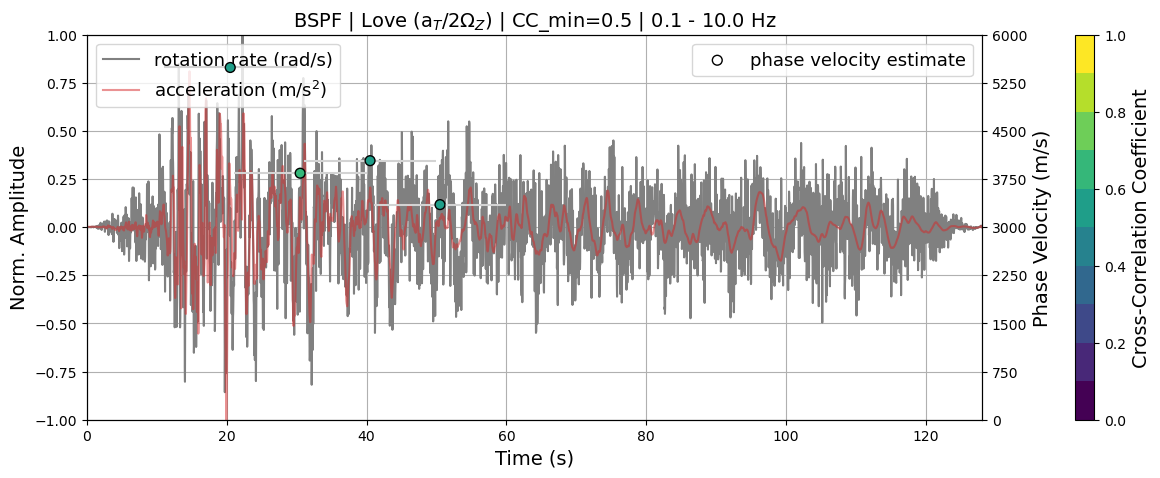

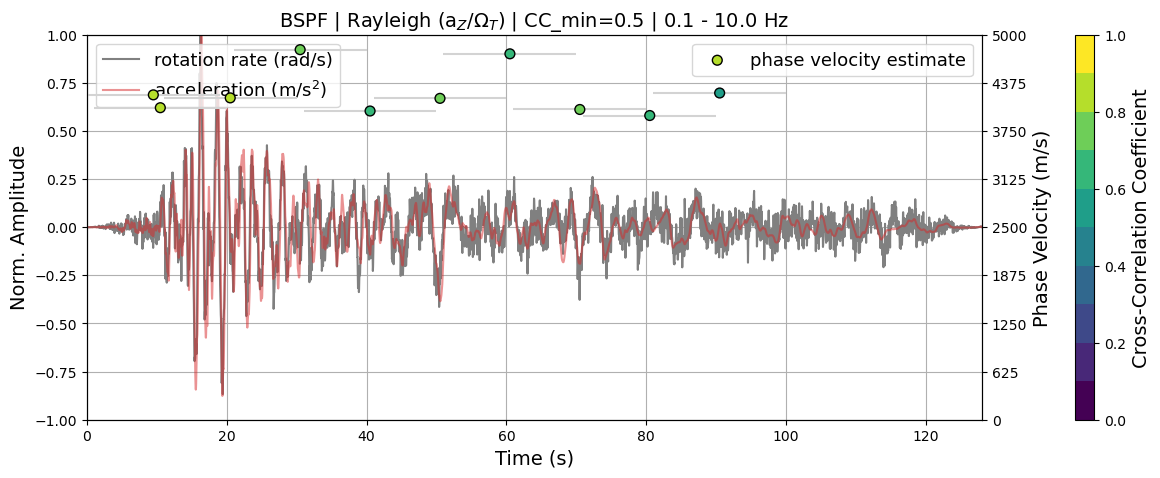

In [155]:
out = __compute_velocity_from_amplitude_ratio(
                                                rot,
                                                acc,
                                                baz=baz,
                                                mode='love',
                                                win_time_s=1/fmin,
                                                cc_thres=0.5,
                                                overlap=0.9,
                                                flim=(fmin, fmax),
                                                plot=True,
)
out['fig'].savefig(config['path_to_figs']+f"BSPF_M62_velocity_love_{rot[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


out = __compute_velocity_from_amplitude_ratio(
                                                rot,
                                                acc,
                                                baz=baz,
                                                mode='rayleigh',
                                                win_time_s=1/fmin,
                                                cc_thres=0.5,
                                                overlap=0.9,
                                                flim=(fmin, fmax),
                                                plot=True,
)
out['fig'].savefig(config['path_to_figs']+f"BSPF_M62_velocity_rayleigh_{rot[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


# 

### Velocity in F-Bands

In [156]:
from functions.get_octave_bands import __get_octave_bands

In [157]:
def __estimate_velocity_in_fbands(rot, acc, ffmin, ffmax):

    # flower, fupper, fcenter = __get_octave_bands(0.01, 10, fband_type="one-third-octave", plot=False)
    flower, fupper, fcenter = __get_octave_bands(ffmin, ffmax, fband_type="octave", plot=False)
    fbands = [(f1, f2) for f1, f2 in zip(flower, fupper)]


    # fbands = [(0.5,0.7), (0.7,0.9), (0.8,1.0), (1.0,2.0), (1.0,5.0), (3.0,8.0), (5.0,12.0)]

    love_velo, rayl_velo = [], []
    r_flabels, l_flabels = [], []

    velo = np.arange(0, 5000, 250)


    for fmin, fmax in fbands:

        # acc = st0.select(station="PFO").copy();
        # # rot = st0.select(station="BSPF").copy();
        # rot = st0.select(station="RPFO").copy();

        rot = rot.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);
        acc = acc.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);

        velo = np.arange(0, 5000, 250)

        cc_threshold = 0.2
        overlap = 0.9

        out_l = __compute_velocity_from_amplitude_ratio(
                                                        rot,
                                                        acc,
                                                        baz=baz,
                                                        mode='love',
                                                        win_time_s=2/fmin,
                                                        cc_thres=cc_threshold,
                                                        overlap=overlap,
                                                        flim=(fmin, fmax),
                                                        plot=False,
        )

        lvel = out_l['velocity'][~np.isnan(out_l['velocity'])]
        if len(lvel) > 0:
            hist = np.histogram(out_l['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=(out_l['ccoef']*100).astype(int), density=False)
            data = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip(hist[0], hist[1])], axis=0 )
            love_velo.append(data)
            l_flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")

        out_r = __compute_velocity_from_amplitude_ratio(
                                                        rot,
                                                        acc,
                                                        baz=baz,
                                                        mode='rayleigh',
                                                        win_time_s=2/fmin,
                                                        cc_thres=cc_threshold,
                                                        overlap=overlap,
                                                        flim=(fmin, fmax),
                                                        plot=False,
        )

        rvel = out_r['velocity'][~np.isnan(out_r['velocity'])]
        if len(rvel) > 0:
            hist = np.histogram(out_r['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=(out_r['ccoef']*100).astype(int), density=False)
            data = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip(hist[0], hist[1])], axis=0 )
            rayl_velo.append(data)
            r_flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")


    #     plt.figure()
    #     plt.hist(out_l['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=out_l['ccoef'], density=False, rwidth=0.9)
    #     plt.show();

    #     plt.figure()
    #     plt.hist(out_r['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=out_r['ccoef'], density=False, rwidth=0.9)
    #     plt.show();


    fig1, ax = plt.subplots(1, 1, figsize=(15,5))

    data = love_velo

    ax.yaxis.grid(True)
    ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Love Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=l_flabels)

    if {rot[0].stats.station} == "RPFO":
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station}{rot[0].stats.location[0]} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")
    else:
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")

    plt.show();




    fig2, ax = plt.subplots(1, 1, figsize=(15,5))

    data = rayl_velo

    ax.yaxis.grid(True)
    ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=r_flabels)

    if {rot[0].stats.station} == "RPFO":
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station}{rot[0].stats.location[0]} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")
    else:
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")

    plt.show();
    return fig1, fig2

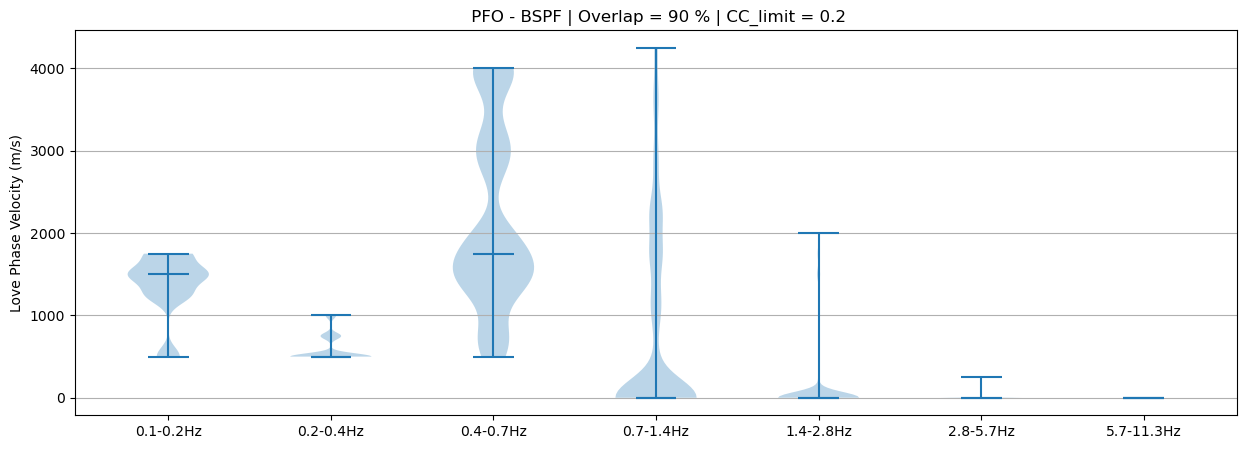

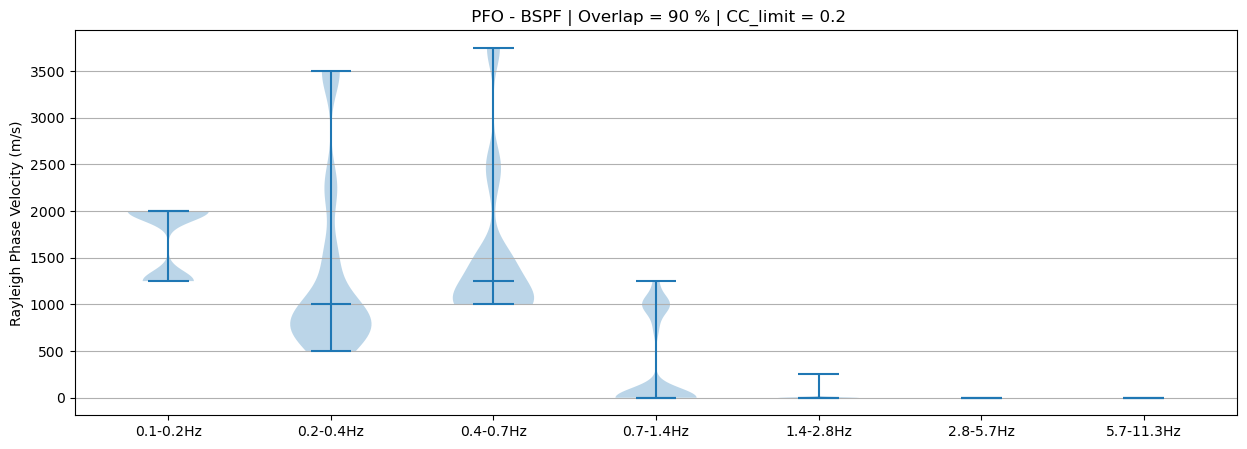

In [158]:
fig1, fig2 = __estimate_velocity_in_fbands(rot, acc, fmin, fmax)

fig1.savefig(config['path_to_figs']+f"BSFP_M62_Love_velocity_fbands_{rot[0].stats.station}_{rot[0].stats.location}.png", format="png", dpi=200, bbox_inches='tight')
fig2.savefig(config['path_to_figs']+f"BSFP_M62_Rayleigh_velocity_fbands_{rot[0].stats.station}_{rot[0].stats.location}.png", format="png", dpi=200, bbox_inches='tight')

## BAZ in F-Bands ??

In [ ]:
def __estimate_baz_in_fbands():

    # flower, fupper, fcenter = __get_octave_bands(0.5, 10, fband_type="one-third-octave", plot=False)
    flower, fupper, fcenter = __get_octave_bands(0.5, 10, fband_type="octave", plot=False)
    fbands = [(f1, f2) for f1, f2 in zip(flower, fupper)]


    # fbands = [(0.5,0.7), (0.7,0.9), (0.8,1.0), (1.0,2.0), (1.0,5.0), (3.0,8.0)]

    backazis = []
    flabels = []

    angles = np.arange(0, 365, 5)

    for fmin, fmax in fbands:

        print(fmin, fmax)

        acc = st0.select(station="PFO").copy();
        rot = st0.select(station="BSPF").copy();
        # rot = st0.select(station="RPFO").copy();

        rot = rot.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);
        acc = acc.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);

        win_time_s = 1/fmin
        cc_threshold = 0.2
        overlap = 0.9



        out3 = __compute_backazimuth_tangent(
                                            rot,
                                            acc,
                                            win_time_s=win_time_s,
                                            overlap=overlap,
                                            baz_theo=None,
                                            cc_thres=cc_threshold,
                                            plot=False,
        )


        if len(out3['baz_est']) > 0:
            hist = np.histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=(out3['ccoef']*100).astype(int), density=False)
            dat = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip( hist[0], hist[1])], axis=0 )
            backazis.append(dat)
            flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")
        else:
            print(f"empty results")


    fig, ax = plt.subplots(1, 1, figsize=(15,5))


    ax.yaxis.grid(True)

    ax.violinplot(backazis, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=flabels)

    ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")

    ax.set_ylim(0, 360)

    # fig.savefig(config['path_to_figs']+f"BSFP_Rayleigh_velocity_fbands_{rot[0].stats.station}.png", format="png", dpi=200, bbox_inches='tight')

    plt.show();

# __estimate_baz_in_fbands()